# exp5 Kaggle 참여해보기 : 집값 예측

### 시도해볼 수 있는 방법들
- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

## 1. 데이터 불러오기

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
%matplotlib inline
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## 2. 데이터 전처리

### 2-1. 이상점(Outliers)
- 이상점 체크를 하여 제거해주자.


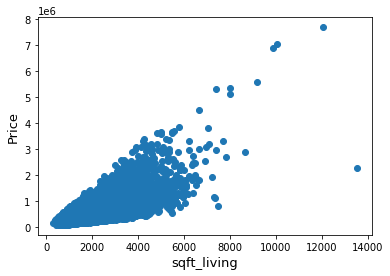

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = data['sqft_living'], y = data['price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('sqft_living', fontsize=13)
plt.show()

sqft_living이 12000이 넘고 price는 3,000,000이 넘지 않는 점이 보인다. 이상점으로서 제거해주도록 하자.

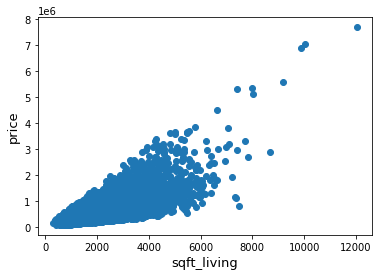

In [5]:
#Deleting outliers
data = data.drop(data[(data['sqft_living']>12000) & 
                         (data['price']<3000000)].index)

fig, ax = plt.subplots()
ax.scatter(data['sqft_living'], data['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('sqft_living', fontsize=13)
plt.show()

조건에 맞는 이상점이 잘 제거된 것을 확인할 수 있다. 이외에도 이상점은 칼럼마다 존재하겠지만 test 데이터에도 이상점이 존재할 가능성이 있고, 존재할 경우 오히려 모델에 부정적으로 작용할 수 있다. 또한, 이상점에 대한 모델의 강인함을 키우는데 도움이 될 수 있다.

### 2-2. 결측치 확인
- 결측치를 확인 해준다.
- 불필요한 id 칼럼을 제거한다.

In [6]:
# price 칼럼 분리
y = data['price']
del data['price']

In [7]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

<AxesSubplot:>

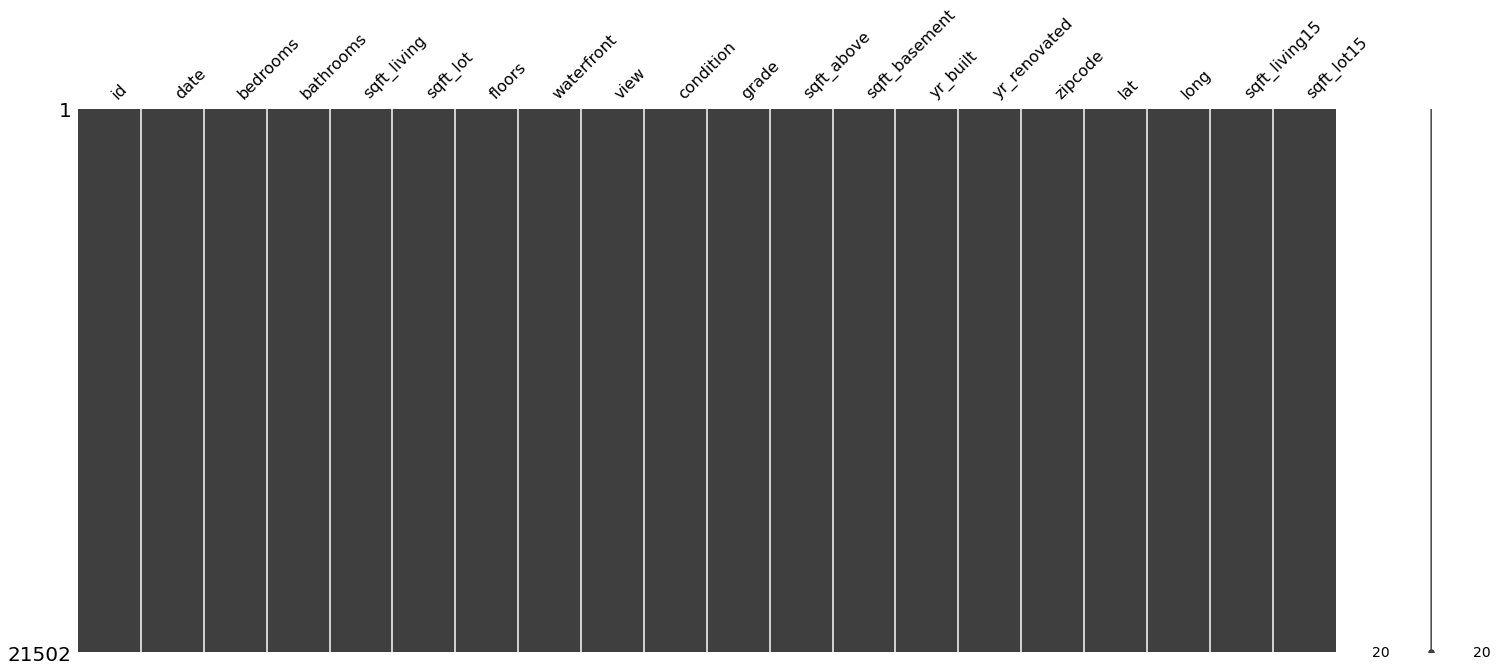

In [8]:
msno.matrix(data)

In [9]:
# 더블 체크
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [10]:
# id 칼럼 따로 저장해두기.
sub_id = data['id'][train_len:]
del data['id']

# date변수를 연도와 월의 정보만 담긴 범주형 변수로 만든다.
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

In [11]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 2-3. 변수들의 분포 확인
skewed가 심하게 된 data는 모델의 prediction값에 부정적인 영향을 미치므로 data를 정규화 등의 방법으로 다듬어주자.

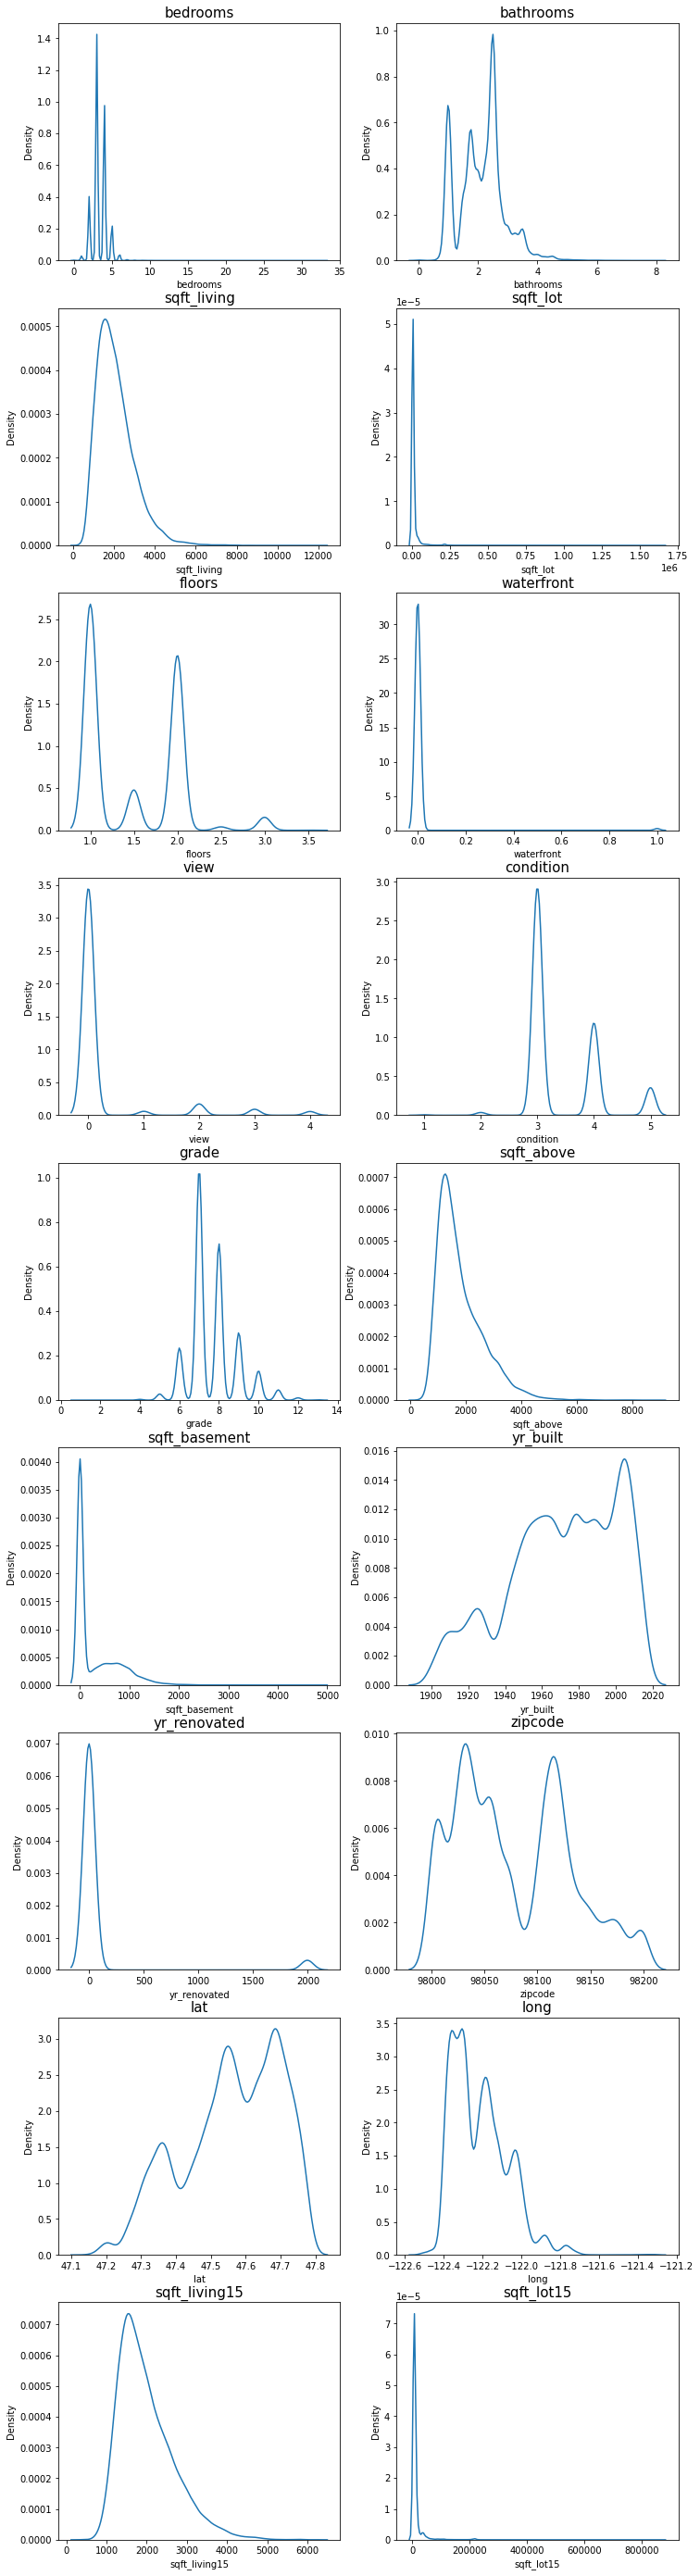

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수들이 skewed되어 있어 이 변수들을 로그 변환(log_scaling)을 통해 데이터 분포를 정규분포에 근접하게 만들 수 있다. np.log1p() 사용.

In [13]:
skewed_col = [
    'bedrooms', 
    'sqft_living', 
    'sqft_lot', 
    'sqft_above', 
    'sqft_basement', 
    'sqft_lot15', 
    'sqft_living15'
]

for c in skewed_col:
    data[c] = np.log1p(data[c].values)

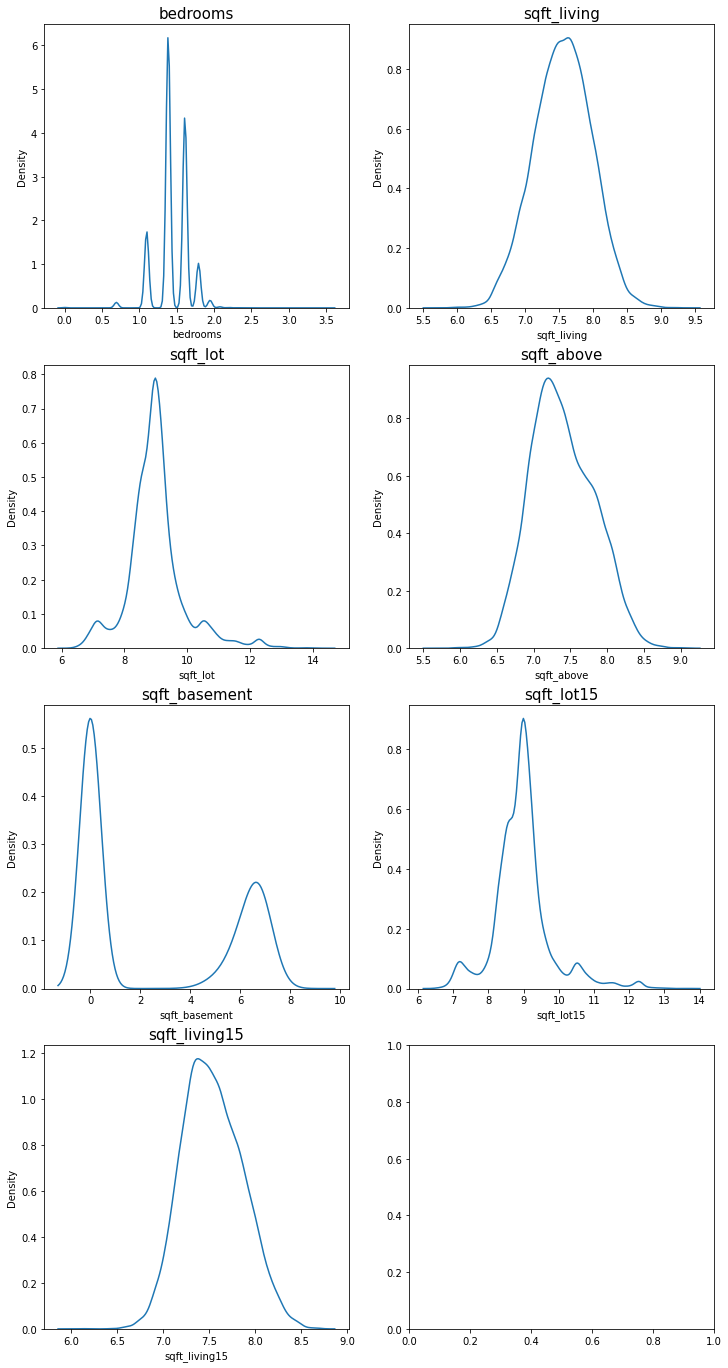

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skewed_col[count]], ax=ax[row][col])
        ax[row][col].set_title(skewed_col[count], fontsize=15)
        count += 1

아까보다 분포가 가운데로 이동하며 좋아졌음을 확인할 수 있다. Target varibale인 price도 확인해준다. 마찬가지로 매우 rigth skewed되어 있기 때문에 log transformation해주어 마무리한다.

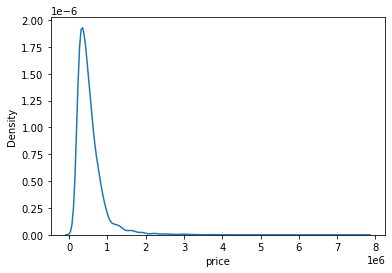

In [15]:
sns.kdeplot(y)
plt.show()

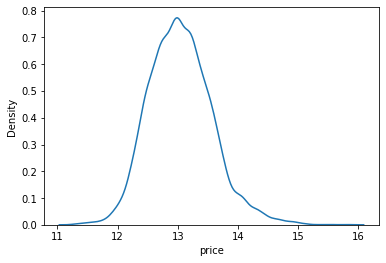

In [16]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [17]:
# train과 test로 다시 나눠준다.
test = data.iloc[train_len:, :] 
train = data.iloc[:train_len, :] 

## 3. 모델링

- kaggle 에서 비슷한 주제로 열린 대회에서 공개된 노트북 중 좋은 성능을 낼 수 있는 팁에 대한 노트북이 있어 참고하며, 모델들은 그대로 사용해보았다.
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook

- lasso, ENet, KRR, GBoost, XGB, LGBM 을 사용.
- Average Blending 사용.


In [18]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [19]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [20]:
random_state = 2020
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=random_state))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=random_state))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=random_state)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, 
                             random_state=random_state, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=50,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55,
                             )

# models = [lasso, ENet, KRR, GBoost, model_xgb, model_lgb]
models = [GBoost, model_xgb, model_lgb]


In [76]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

[15:29:51] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,RMSE
LGBMRegressor,110671.649569
XGBRegressor,103826.944456
GradientBoostingRegressor,102326.593944


### [RMSE 결과]
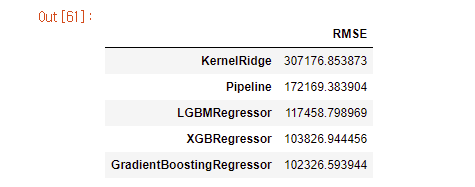

각 모델에 대한 RMSE 값을 출력해보았고 결과가 안좋은 모델들에 대한 출력은 이후로 하지 않았다.
아래의 결과는 위의 하이퍼 파라미터들 중에 max_depth와 n_estimators를 1.5배씩 올려준 결과이다.

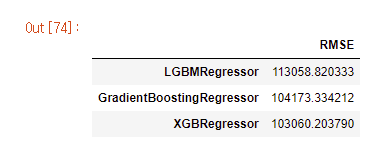

최종적인 모델의 예측값은 성능이 좋은 모델 3가지(LGBM, XGBR, GBoost)로 Averaging Blending을 사용하였다.

In [78]:
def AveragingBlending(models, train, y, test):
    for model in models : 
        model.fit(train.values, y)
    
    predictions = np.column_stack([
        model.predict(test.values) for model in models
    ])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models, train, y, test)

[15:37:03] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [81]:
submission = pd.DataFrame(data={'id':sub_id,'price':np.expm1(y_pred)})
submission

,id,price
0,15035,5.276196e+05
1,15036,4.735998e+05
2,15037,1.343218e+06
3,15038,3.079483e+05
4,15039,3.315471e+05
...,...,...
6463,21498,2.510795e+05
6464,21499,4.113534e+05
6465,21500,4.785559e+05
6466,21501,3.174952e+05


In [21]:
def save_submission(prediction, model_name, rmse=None):
    
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(
        data_dir, model_name, rmse)
    submission.to_csv(submission_csv_path, index=False)
    print('{}saved !'.format(submission_csv_path))

In [91]:
save_submission(y_pred, 'avg_blend', rmse='103060') # rmse 최저값으로 넣어줌.

/aiffel/aiffel/kaggle_kakr_housing/data/submission_avg_blend_RMSE_103060.csvsaved !


## 4. Gradient Boosting Regressor (2차 제출)
Average blending은 과적합을 피하기 위해 사용하는 목적이 강하다고 보기 때문에 단일 모델을 사용하면 Score가 더 높지 않을까하는 생각으로 2차 제출은 Gradient boosting regressor로 결과를 하나 더 제출해보았다.

In [23]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=random_state)

In [25]:

models = [GBoost]

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,102326.593944


In [31]:
prediction = GBoost.predict(test)
prediction = np.expm1(prediction)


data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = prediction
submission.head()

,id,price
0,15035,5.572505e+05
1,15036,4.590076e+05
2,15037,1.327288e+06
3,15038,3.289442e+05
4,15039,3.357597e+05


In [32]:
submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, 'GBoost', '103060')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_GBoost_RMSE_103060.csv


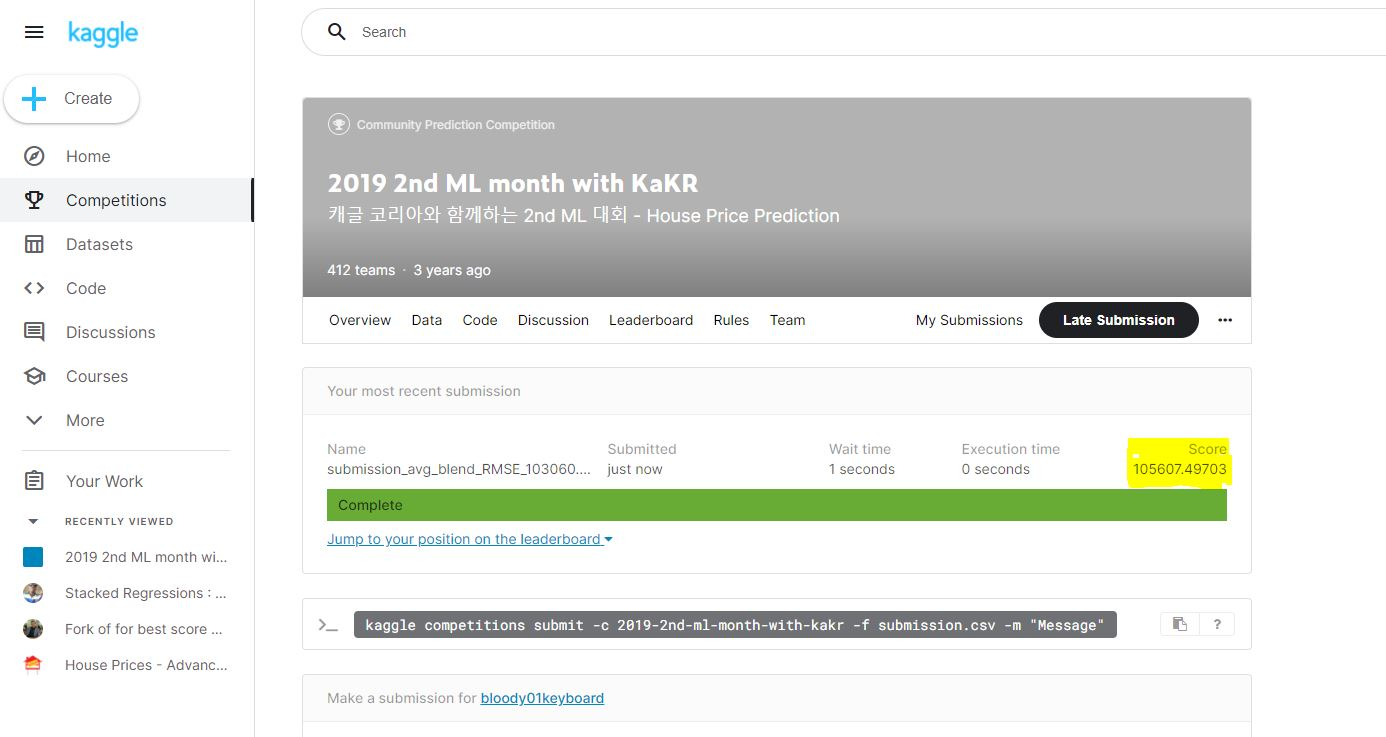



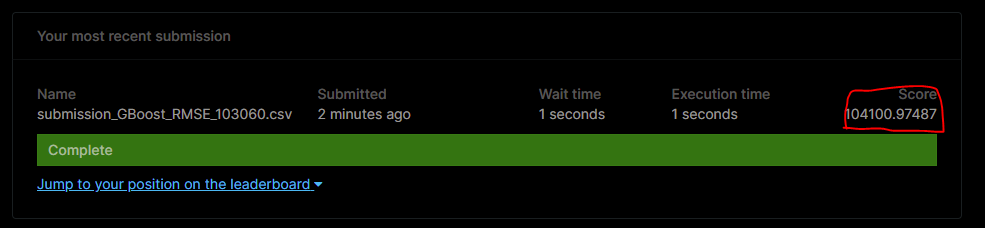

---
## 5. 회고

#### 1차 제출은 averaging blending을 적용하여 prediction의 평균값을 계산하여 결과를 제출했다. 결과는 105607.50 점이었다. blending에 대한 이해가 부족한 상태지만 공부했던 것과는 다르게 모델별 가중치도 주지 않았고, hold out validation set으로 다음 레이어(모델)을 학습시킨다는 부분도 코드에서는 드러나지 않아서, 이 부분은 추가로 공부를 해서 Ensemble, stacking, blending에 대한 개념들을 명확히 해야할 필요가 있다. 그래서, 과적합을 피하기 위한 목적이 큰 blending을 이번에 굳이 사용할 이유가 없다고 판단되어 사장 성능을 좋게 보인 GBoost 단일 모델로 prediction 값을 출력하여 다시 제출해보았다. 결과적으로 104100.97점으로 더 좋은 점수를 받을 수 있었다. 
이번 노드는 정말 재밌었고, 개인적으로 캐글에 관심이 많아 곧 스터디 개설과 데이콘 대회에 나가보려한다.

- 하이퍼 파라미터들을 통해 모델을 더욱 고도화 시킨다고 결과가 잘 나오는 것이 아님.
- 모델별 공부를 할 때 파라미터 별로 중요도나 그에 대한 의미를 정확하게 공부할 필요가 있음.
- Ensemble, stacking, blending 에 대한 공부가 더 필요함. 특히, stacking 방식이 캐글에서 점수를 높이는데 유용해 보임.
